In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In this work, we will find out which features give the best forecast on the training set and on the test set. What is interesting is that these features do not coincide quite strongly - some give a good forecast for train and others - for test.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [5]:
test_PassengerId = test_data['PassengerId']

In [6]:
train_test_data = pd.concat([train_data, test_data], ignore_index=True)
train_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


# EDA

Let's look at how similar the train_data and test_data datasets are.¶

In [7]:
categorical_columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

numeric_columns = ['Age', 'Fare']

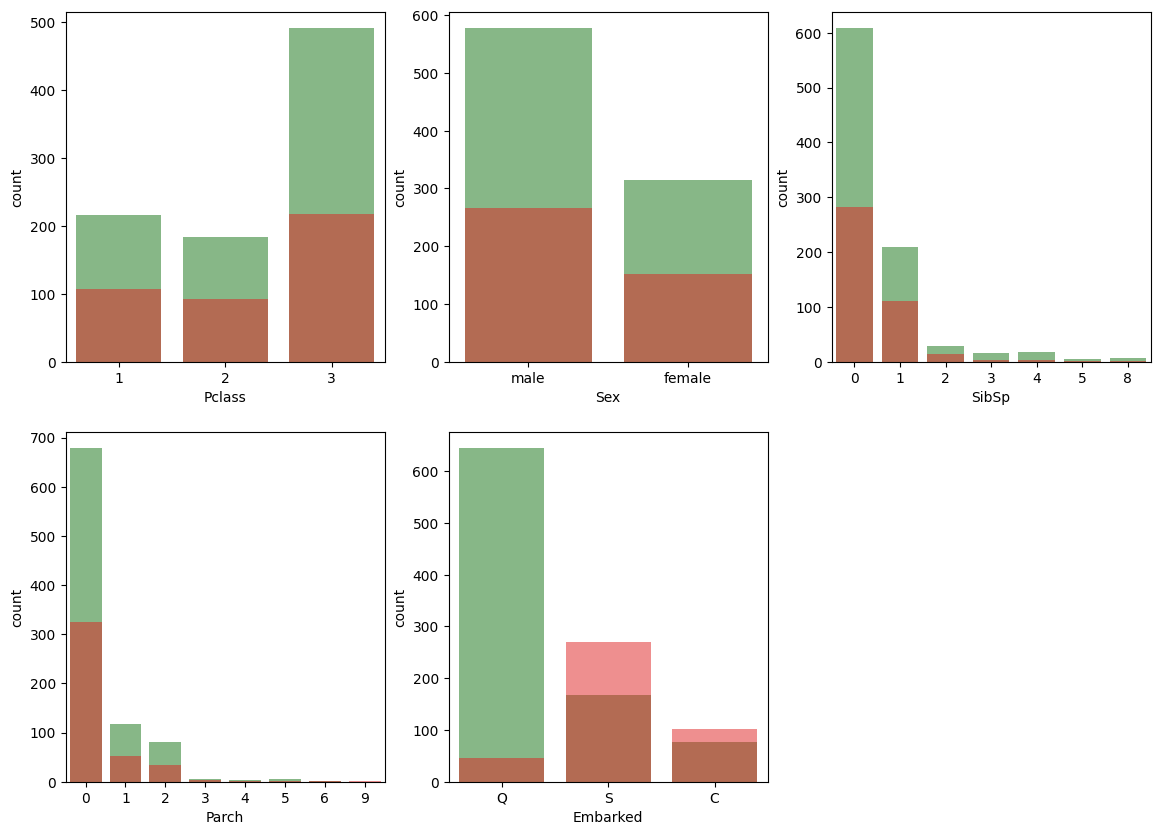

In [8]:
fig = plt.figure(figsize=(14, 10))

for i, column in enumerate(categorical_columns):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=train_data, x=column, color='g', alpha= 0.5)
    sns.countplot(data=test_data, x=column, color='r', alpha= 0.5)

#### We see a clear discrepancy in Embarked.

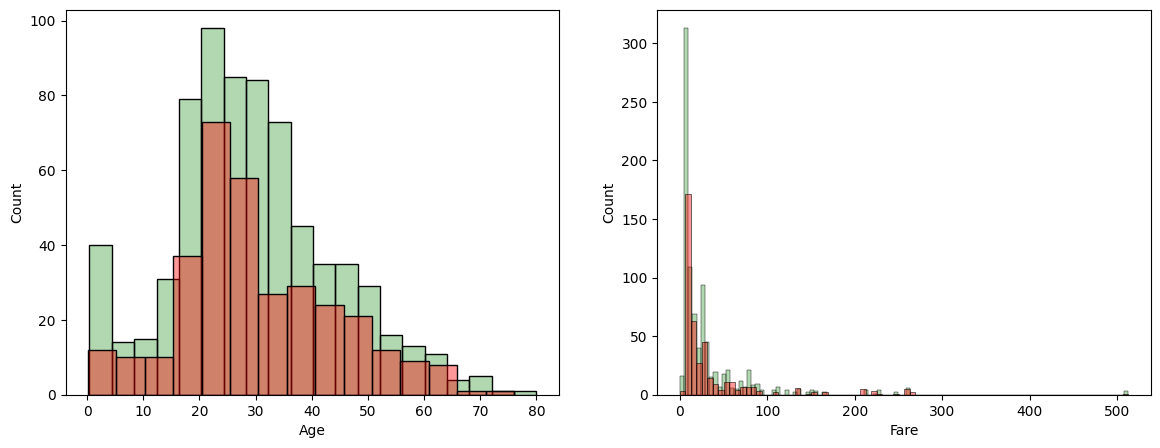

In [9]:
fig = plt.figure(figsize=(14, 5))

for i, column in enumerate(numeric_columns):
    plt.subplot(1, 2, i+1)
    sns.histplot(data=train_data, x=column, color='g', alpha= 0.3)
    sns.histplot(data=test_data, x=column, color='r', alpha= 0.4)

There are significantly more small children on train than on test.

In [10]:
train_data.loc[train_data['Cabin'].isnull(), 'Cabin'] = 'NA'
train_data['Is_cabin'] = 1
train_data.loc[train_data['Cabin'] == 'NA', 'Is_cabin'] = 0

test_data.loc[test_data['Cabin'].isnull(), 'Cabin'] = 'NA'
test_data['Is_cabin'] = 1
test_data.loc[test_data['Cabin'] == 'NA', 'Is_cabin'] = 0

train_test_data.loc[train_test_data['Cabin'].isnull(), 'Cabin'] = 'NA'
train_test_data['Is_cabin'] = 1
train_test_data.loc[train_test_data['Cabin'] == 'NA', 'Is_cabin'] = 0

In [11]:
train_data['Is_cabin'].value_counts(), test_data['Is_cabin'].value_counts()

(Is_cabin
 0    687
 1    204
 Name: count, dtype: int64,
 Is_cabin
 0    327
 1     91
 Name: count, dtype: int64)

Let's look at how features affect survival

#### Pclass

In [12]:
train_data.groupby('Pclass').agg({'Survived': 'mean'})

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


#### Sex

In [13]:
train_data.groupby('Sex').agg({'Survived': 'mean'})

,Survived
Sex,
female,0.742038
male,0.188908


#### SibSp, Parch and Family_size

In [14]:
train_data.groupby('SibSp').agg({'Survived': 'mean'})

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [15]:
train_data.groupby('Parch').agg({'Survived': 'mean'})

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


Let's create the Family Size feature and see how it affects survival

In [16]:
train_test_data['Family_size'] = train_test_data.SibSp + train_test_data.Parch + 1
train_data['Family_size'] = train_data.SibSp + train_test_data.Parch + 1   

Let's replace sex with 0 and 1 for ease of analysis.

In [17]:
train_data.loc[train_data['Sex'] == 'female', 'Sex'], train_test_data.loc[train_test_data['Sex'] == 'female', 'Sex'] = 0, 0
train_data.loc[train_data['Sex'] == 'male', 'Sex'], train_test_data.loc[train_test_data['Sex'] == 'male', 'Sex'] = 1, 1

In [18]:
train_data.groupby('Family_size').agg({'Survived': ['mean', 'count'], 'Pclass': 'mean', 'Sex': 'mean'}).reset_index()

Family_size  Survived          Pclass       Sex
                   mean count      mean      mean
0         1.0  0.303538   537  2.400372  0.765363
1         2.0  0.552795   161  1.919255  0.459627
2         3.0  0.578431   102  2.225490  0.519608
3         4.0  0.724138    29  2.068966  0.344828
4         5.0  0.200000    15  2.666667       0.2
5         6.0  0.136364    22  2.590909  0.636364
6         7.0  0.333333    12  3.000000  0.333333
7         8.0  0.000000     6  3.000000  0.666667
8        11.0  0.000000     7  3.000000  0.571429

Single passengers are less likely to survive than family passengers. But most likely this may be due to Pclass and Sex. Taking into account the influence of family size on survival, we will create the Is_alon feature.

In [19]:
train_test_data['Is_alon'] = 0
train_test_data.loc[train_test_data['Family_size'] == 1, 'Is_alon'] = 1

#### Age

In [20]:
train_data['Age_categories'] = pd.cut(train_data['Age'], 20, precision=0)

In [21]:
data = train_data.query('Sex == 0').groupby(['Age_categories']).agg({'Survived': ['mean',  'count'], 'Pclass': 'mean' }).reset_index()
data

Age_categories  Survived          Pclass
                       mean count      mean
0      (0.0, 4.0]  0.705882    17  2.647059
1      (4.0, 8.0]  0.777778     9  2.555556
2     (8.0, 12.0]  0.000000     6  3.000000
3    (12.0, 16.0]  0.823529    17  2.294118
4    (16.0, 20.0]  0.714286    28  2.214286
5    (20.0, 24.0]  0.800000    40  2.075000
6    (24.0, 28.0]  0.652174    23  2.347826
7    (28.0, 32.0]  0.724138    29  2.103448
8    (32.0, 36.0]  1.000000    26  1.653846
9    (36.0, 40.0]  0.722222    18  1.777778
10   (40.0, 44.0]  0.666667    12  1.833333
11   (44.0, 48.0]  0.583333    12  2.083333
12   (48.0, 52.0]  0.900000    10  1.300000
13   (52.0, 56.0]  1.000000     6  1.333333
14   (56.0, 60.0]  0.800000     5  1.200000
15   (60.0, 64.0]  1.000000     3  1.666667
16   (64.0, 68.0]       NaN     0       NaN
17   (68.0, 72.0]       NaN     0       NaN
18   (72.0, 76.0]       NaN     0       NaN
19   (76.0, 80.0]       NaN     0       NaN

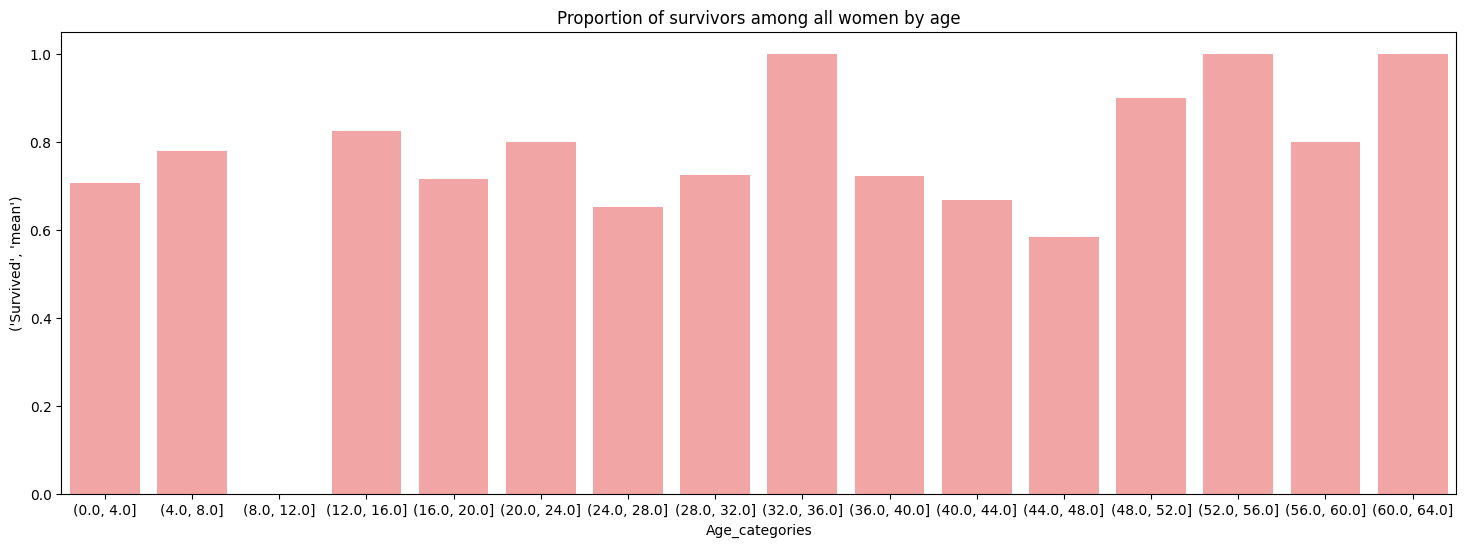

In [22]:
fig,ax =plt.subplots(1, 1, figsize=[18,6])
sns.barplot(x='Age_categories', y=('Survived', 'mean'), data=data, color ='r', alpha= 0.4)
ax.set(title = 'Proportion of survivors among all women by age')
ax.set_xlim(-0.5, 15.5);

In [23]:
data = train_data.query('Sex == 1').groupby(['Age_categories']).agg({'Survived': ['mean',  'count'], 'Pclass': 'mean' }).reset_index()
data

Age_categories  Survived          Pclass
                       mean count      mean
0      (0.0, 4.0]  0.652174    23  2.478261
1      (4.0, 8.0]  0.400000     5  2.800000
2     (8.0, 12.0]  0.444444     9  2.777778
3    (12.0, 16.0]  0.071429    14  2.857143
4    (16.0, 20.0]  0.137255    51  2.686275
5    (20.0, 24.0]  0.068966    58  2.620690
6    (24.0, 28.0]  0.241935    62  2.435484
7    (28.0, 32.0]  0.254545    55  2.472727
8    (32.0, 36.0]  0.191489    47  2.234043
9    (36.0, 40.0]  0.148148    27  2.074074
10   (40.0, 44.0]  0.173913    23  2.434783
11   (44.0, 48.0]  0.217391    23  1.652174
12   (48.0, 52.0]  0.263158    19  1.736842
13   (52.0, 56.0]  0.100000    10  1.500000
14   (56.0, 60.0]  0.125000     8  1.625000
15   (60.0, 64.0]  0.125000     8  1.375000
16   (64.0, 68.0]  0.000000     4  1.750000
17   (68.0, 72.0]  0.000000     5  1.600000
18   (72.0, 76.0]  0.000000     1  3.000000
19   (76.0, 80.0]  1.000000     1  1.000000

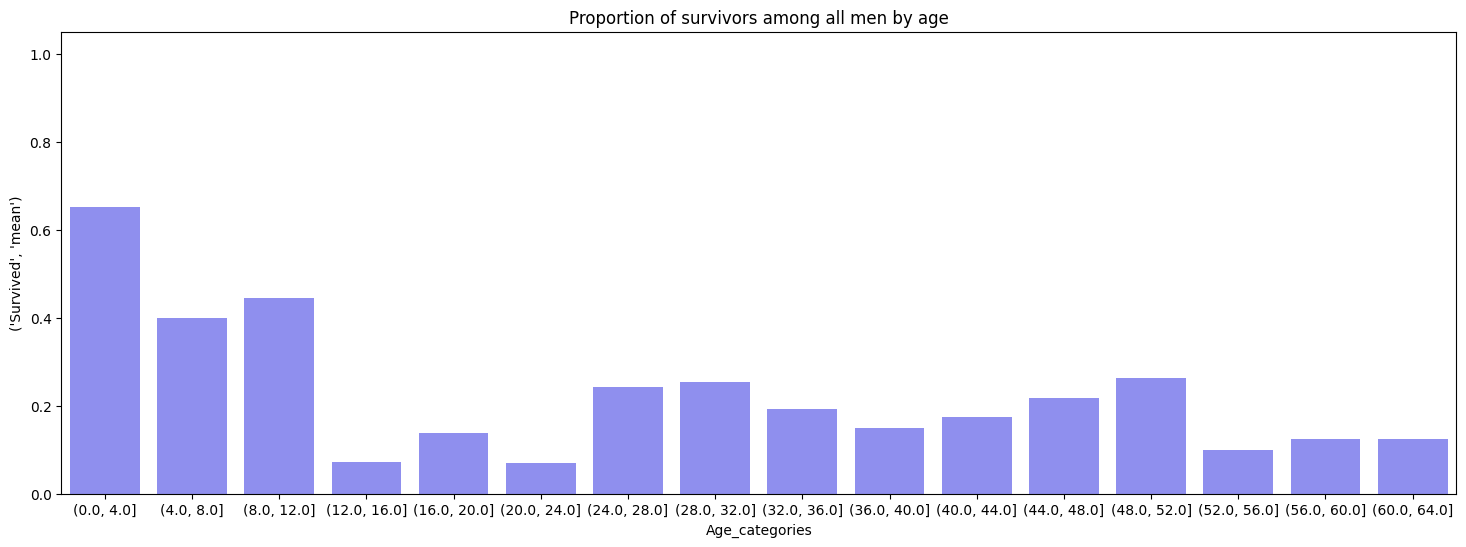

In [24]:
fig,ax =plt.subplots(1, 1, figsize=[18,6])
sns.barplot(x='Age_categories', y=('Survived', 'mean'), data=data, color ='b', alpha= 0.5)
ax.set(title = 'Proportion of survivors among all men by age')
ax.set_xlim(-0.5, 15.5);

Among women, survival clearly does not depend on age (except for the anomaly from 8 to 12 years). Among men, the survival rate of boys under 12 years of age is clearly higher, and this is understandable.

### Fare

In [25]:
train_data['Fare_categories'] = pd.cut(train_data['Fare'], 20, precision=0)

In [26]:
data = train_data.groupby(['Fare_categories']).agg({'Survived': ['mean',  'count'], 'Pclass': 'mean' }).reset_index()
data

Fare_categories  Survived          Pclass
                        mean count      mean
0     (-1.0, 26.0]  0.284698   562  2.768683
1     (26.0, 51.0]  0.429412   170  1.805882
2     (51.0, 77.0]  0.597015    67  1.522388
3    (77.0, 102.0]  0.769231    39  1.000000
4   (102.0, 128.0]  0.733333    15  1.000000
5   (128.0, 154.0]  0.750000    16  1.000000
6   (154.0, 179.0]  1.000000     2  1.000000
7   (179.0, 205.0]       NaN     0       NaN
8   (205.0, 231.0]  0.666667     9  1.000000
9   (231.0, 256.0]  0.500000     2  1.000000
10  (256.0, 282.0]  0.666667     6  1.000000
11  (282.0, 307.0]       NaN     0       NaN
12  (307.0, 333.0]       NaN     0       NaN
13  (333.0, 359.0]       NaN     0       NaN
14  (359.0, 384.0]       NaN     0       NaN
15  (384.0, 410.0]       NaN     0       NaN
16  (410.0, 435.0]       NaN     0       NaN
17  (435.0, 461.0]       NaN     0       NaN
18  (461.0, 487.0]       NaN     0       NaN
19  (487.0, 512.0]  1.000000     3  1.000000

### Cabin

Let's see how the survival rate of passengers differs depending on whether the passenger's cabin is known.

In [27]:
train_data[train_data['Cabin'] == 'NA'].groupby(['Sex', 'Pclass'])['Survived'].mean()

Sex  Pclass
0    1         1.000000
     2         0.924242
     3         0.492754
1    1         0.222222
     2         0.127451
     3         0.131965
Name: Survived, dtype: float64

In [28]:
train_data[train_data['Cabin'] != 'NA'].groupby(['Sex', 'Pclass'])['Survived'].mean()

Sex  Pclass
0    1         0.962963
     2         0.900000
     3         0.666667
1    1         0.410526
     2         0.666667
     3         0.333333
Name: Survived, dtype: float64

If the cabin is known, then the survival rate is significantly higher for women of 3rd class and for all men. This is somehow explained by the system for recording passengers during rescue. The Is_cabin attribute was created earlier.

The cabin code contains an indication of the deck. Let's create the Deck attribute and see how it affects survivability.

In [29]:
train_data['Deck'] = train_data['Cabin'].apply(lambda x: x[0] if x != 'NA' else 'NA')
train_test_data['Deck'] = train_test_data['Cabin'].apply(lambda x: x[0] if x != 'NA' else 'NA')

In [30]:
train_data.groupby('Deck').agg({'Survived': ['mean', 'count'], 'Pclass': 'mean', 'Sex': 'mean'})

Survived          Pclass       Sex
          mean count      mean      mean
Deck                                    
A     0.466667    15  1.000000  0.933333
B     0.744681    47  1.000000  0.425532
C     0.593220    59  1.000000  0.542373
D     0.757576    33  1.121212  0.454545
E     0.750000    32  1.312500   0.53125
F     0.615385    13  2.384615  0.615385
G     0.500000     4  3.000000       0.0
NA    0.299854   687  2.639010  0.684134
T     0.000000     1  1.000000       1.0

### Embarked

In [31]:
train_data.groupby('Embarked').agg({'Survived': 'mean', 'PassengerId': 'count', 'Pclass': 'mean', 'Sex': 'mean'})

,Survived,PassengerId,Pclass,Sex
Embarked,,,,
C,0.553571,168,1.886905,0.565476
Q,0.389610,77,2.909091,0.532468
S,0.336957,644,2.350932,0.684783


Embarked affects survivability, but comes as we see from the combination of Pclass and Sex.

## Creating additional features and filling in gaps

Let's create the Title attribute and use it to fill in the age.

In [32]:
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

train_test_data['Title'] = train_test_data['Name'].apply(extract_title)

In [33]:
train_test_data.groupby('Title').agg({'Survived': ['mean', 'count'], 'Pclass': 'mean', 'Sex': 'mean' })\
    .sort_values(by= ('Survived', 'count'), ascending= False)

Survived          Pclass    Sex
                  mean count      mean   mean
Title                                        
Mr            0.156673   517  2.381770    1.0
Miss          0.697802   182  2.346154    0.0
Mrs           0.792000   125  1.939086    0.0
Master        0.575000    40  2.655738    1.0
Dr            0.428571     7  1.250000  0.875
Rev           0.000000     6  2.000000    1.0
Major         0.500000     2  1.000000    1.0
Col           0.500000     2  1.000000    1.0
Mlle          1.000000     2  1.000000    0.0
Sir           1.000000     1  1.000000    1.0
Ms            1.000000     1  2.500000    0.0
Capt          0.000000     1  1.000000    1.0
Mme           1.000000     1  1.000000    0.0
Lady          1.000000     1  1.000000    0.0
Jonkheer      0.000000     1  1.000000    1.0
Don           0.000000     1  1.000000    1.0
the Countess  1.000000     1  1.000000    0.0
Dona               NaN     0  1.000000    0.0

Let's group

In [34]:
Mrs = ['Ms']
Aristocrat_male = ['Dr', 'Don', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer']
Aristocrat_female = ['Mlle', 'Mme', 'Lady', 'the Countess', 'Dona']

train_test_data.loc[train_test_data['Title'].isin(Mrs), 'Title'] = 'Mrs'
train_test_data.loc[train_test_data['Title'].isin(Aristocrat_male), 'Title'] = 'Aristocrat_male'
train_test_data.loc[train_test_data['Title'].isin(Aristocrat_female), 'Title'] = 'Aristocrat_female'

In [35]:
train_test_data.groupby('Title').agg({'Survived': ['mean', 'count'], 'Pclass': 'mean' })\
    .sort_values(by= ('Survived', 'count'), ascending= False)

Survived          Pclass
                       mean count      mean
Title                                      
Mr                 0.156673   517  2.381770
Miss               0.697802   182  2.346154
Mrs                0.793651   126  1.944724
Master             0.575000    40  2.655738
Aristocrat_male    0.400000    15  1.111111
Rev                0.000000     6  2.000000
Aristocrat_female  1.000000     5  1.000000

#### Fill in the age using the average age value in Title

In [36]:
mean_age_by_title = train_test_data.groupby('Title')['Age'].mean().round(1)

for title, mean_age in mean_age_by_title.items():
    train_test_data.loc[(train_test_data['Age'].isnull()) & (train_test_data['Title'] == title), 'Age'] = mean_age

Fill in Embarked and Fare

In [37]:
train_test_data.loc[train_test_data['Embarked'].isnull(), 'Embarked'] = train_test_data['Embarked'].mode().iloc[0]

In [38]:
train_test_data.loc[train_test_data['Fare'].isnull(), 'Pclass']

1043    3
Name: Pclass, dtype: int64

In [39]:
train_test_data.loc[(train_test_data['Fare'].isnull()), 'Fare'] = train_test_data[train_test_data['Pclass'] == 3]['Fare'].mean()

In [40]:
train_test_data.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Is_cabin         0
Family_size      0
Is_alon          0
Deck             0
Title            0
dtype: int64

Let's create features - Age and Fare intervals

In [41]:
train_test_data['Age_categories'] = pd.cut(train_test_data['Age'], 20, precision=0)

train_test_data['Fare_categories'] = pd.cut(train_test_data['Fare'], 10, precision=0)

In [42]:
train_test_data['Age_categories'].value_counts(), train_test_data['Fare_categories'].value_counts()

(Age_categories
 (32.0, 36.0]    273
 (20.0, 24.0]    210
 (24.0, 28.0]    128
 (28.0, 32.0]    122
 (16.0, 20.0]    114
 (36.0, 40.0]     92
 (44.0, 48.0]     58
 (0.1, 4.0]       51
 (40.0, 44.0]     51
 (12.0, 16.0]     40
 (48.0, 52.0]     38
 (4.0, 8.0]       29
 (52.0, 56.0]     27
 (8.0, 12.0]      22
 (56.0, 60.0]     21
 (60.0, 64.0]     20
 (64.0, 68.0]      5
 (68.0, 72.0]      5
 (72.0, 76.0]      2
 (76.0, 80.0]      1
 Name: count, dtype: int64,
 Fare_categories
 (-1.0, 51.0]      1071
 (51.0, 102.0]      154
 (102.0, 154.0]      42
 (205.0, 256.0]      21
 (256.0, 307.0]      13
 (154.0, 205.0]       4
 (461.0, 512.0]       4
 (307.0, 359.0]       0
 (359.0, 410.0]       0
 (410.0, 461.0]       0
 Name: count, dtype: int64)

#### Let's create a sign (in my opinion important) Family. Since salvation took place in families.¶
The family will contain the last name, number of family members and passenger class.

In [43]:
def extract_surname(name):
    return name.split(',')[0].strip()

train_test_data['Surname'] = train_test_data['Name'].apply(extract_surname)


def family(df):   
    return df['Surname'] + '-' + str(df['Family_size']) + '-' + 'Pclass' + '-' + str(df['Pclass'])  

train_test_data['Family'] = train_test_data.apply(family, axis=1)

In [44]:
train_test_data['Family'].head()

0       Braund-2-Pclass-3
1      Cumings-2-Pclass-1
2    Heikkinen-1-Pclass-3
3     Futrelle-2-Pclass-1
4        Allen-1-Pclass-3
Name: Family, dtype: object

Using an exhaustive search method, we will find the features that give the highest score on validation and the highest score on test data (this code is commented out, it takes a long time to calculate).
To do this, we will use a file with answers (this is available on the Internet).

In [45]:
features = {
    
'features_0' : ['Pclass', 'Sex', 'Family'], 
'features_1' : ['Pclass', 'Sex', 'Age', 'Fare'],   
'features_2' : ['Pclass', 'Sex', 'Age', 'Fare', 'Family_size', 'Age_categories'],    
'features_3' : ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Deck', 'Age_categories'],    
'features_4' : ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Deck', 'Title', 'Age_categories'],     
'features_5' : ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Family_size', 'Deck', 'Title', 'Age_categories'],        
'features_6' : ['Pclass', 'Sex', 'Title'],    
'features_7' : ['Pclass', 'Sex', 'Cabin', 'Title'],    
'features_8' : ['Pclass', 'Sex', 'Parch', 'Deck', 'Family'],    
'features_9': ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title', 'Family'],      
'features_10': ['Pclass', 'Sex', 'Age', 'Parch', 'Embarked', 'Is_alon', 'Family'],     
'All_features': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Is_cabin',
       'Family_size', 'Is_alon', 'Deck', 'Title', 'Age_categories', 'Fare_categories', 'Family']   
}

In [46]:
for key, value in features.items(): 
    
    train_test_data_temp = train_test_data[['Survived'] + value]
    train_test_data_temp = pd.get_dummies(train_test_data_temp)
    
    train_data = train_test_data_temp[train_test_data_temp['Survived'].notnull()] 
    test_data  = train_test_data_temp[train_test_data_temp['Survived'].isnull()] 

    y = train_data['Survived'] 
    
    X = train_data.drop(columns = ['Survived'], axis = 1) 
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

    model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    X_test = test_data.drop(columns = ['Survived'], axis=1)

    model.fit(X, y)

    predictions = model.predict(X_test)

    output = pd.DataFrame({'PassengerId': test_PassengerId, 'Survived': predictions})

    output['Survived'] = output['Survived'].astype(int)

    #differense = (output['Survived'] - output_correct['Survived']).abs().sum()

    #accuracy = round((len(output) - differense) / len(output), 3)
      
    print(f'---------------------------------------------------------------------------------------\n{key} {value}')
    
    print(f'validation score:{round(accuracy_score(y_val, y_pred), 3)}') #,  test score: {accuracy}') 

---------------------------------------------------------------------------------------
features_0 ['Pclass', 'Sex', 'Family']
validation score:0.825
---------------------------------------------------------------------------------------
features_1 ['Pclass', 'Sex', 'Age', 'Fare']
validation score:0.858
---------------------------------------------------------------------------------------
features_2 ['Pclass', 'Sex', 'Age', 'Fare', 'Family_size', 'Age_categories']
validation score:0.862
---------------------------------------------------------------------------------------
features_3 ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Deck', 'Age_categories']
validation score:0.869
---------------------------------------------------------------------------------------
features_4 ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Deck', 'Title', 'Age_categories']
validation score:0.873
---------------------------------------------------------------------------------------
features_5 ['Pclass', 'Sex', 

#### ---------------------------------------------------------------------------------------
#### features_0 ['Pclass', 'Sex', 'Family']

#### validation score: 0.825, test score: 0.782
#### ---------------------------------------------------------------------------------------
#### features_1 ['Pclass', 'Sex', 'Age', 'Fare']

#### validation score: 0.858, test score: 0.746
#### ---------------------------------------------------------------------------------------
#### features_2 ['Pclass', 'Sex', 'Age', 'Fare', 'Family_size', 'Age_categories']

#### validation score: 0.862, test score: 0.725
#### ---------------------------------------------------------------------------------------
#### features_3 ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Deck', 'Age_categories']

#### validation score: 0.869, test score: 0.744
#### ---------------------------------------------------------------------------------------
#### features_4 ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Deck', 'Title', 'Age_categories']

#### validation score: 0.873, test score: 0.742
#### ---------------------------------------------------------------------------------------
#### features_5 ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Family_size', 'Deck', 'Title', 'Age_categories']

#### validation score: 0.877, test score: 0.763
#### ---------------------------------------------------------------------------------------
#### features_6 ['Pclass', 'Sex', 'Title']

#### validation score: 0.784, test score: 0.789
#### ---------------------------------------------------------------------------------------
#### features_7 ['Pclass', 'Sex', 'Cabin', 'Title']

#### validation score: 0.787, test score: 0.794
#### ---------------------------------------------------------------------------------------
#### features_8 ['Pclass', 'Sex', 'Parch', 'Deck', 'Family']

#### validation score: 0.813, test score: 0.799
#### ---------------------------------------------------------------------------------------
#### features_9 ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title', 'Family']

#### validation score: 0.821, test score: 0.801
#### ---------------------------------------------------------------------------------------
#### features_10 ['Pclass', 'Sex', 'Age', 'Parch', 'Embarked', 'Is_alon', 'Family']

#### validation score: 0.828, test score: 0.809
#### ---------------------------------------------------------------------------------------
#### All features ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Is_cabin', 'Family_size', 'Is_alon', 'Deck', 'Title', 'Age_categories', 'Fare_categories', 'Family']
#### validation score: 0.854, test score: 0.773

## Conclusion
### - maximum score on train - 0.877
### - best features on train: 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Family_size', 'Deck', 'Title', 'Age_categories'
### - maximum score on test - 0.809
### - best features on test: 'Pclass', 'Sex', 'Age', 'Parch', 'Embarked', 'Is_alon', 'Family'
### - signs that strongly influence survival work on both train and test
### - traits that have little effect on survivability and derived traits work differently on train and test 
### - 'Title', 'Age_categories' work better on train, 'Is_alon', 'Family' on test

In [47]:
'''
from itertools import combinations

all_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Is_cabin', 'Family_size', 'Is_alon', 
                'Deck', 'Title', 'Age_categories', 'Fare_categories', 'Family']


selected_features = ['Survived', 'Pclass', 'Sex'] 
best_accuracy = 0.0 
best_feature_subset = []

for k in range(1, len(all_features) + 1): 
    for subset in combinations(all_features, k): 
        features_to_try = selected_features + list(subset) 
        # Далее идет ваш код для обучения модели и оценки качества
        
        train_test_data_temp = train_test_data[features_to_try]
        train_test_data_temp = pd.get_dummies(train_test_data_temp)
        train_data = train_test_data_temp[train_test_data_temp['Survived'].notnull()] 
        test_data  = train_test_data_temp[train_test_data_temp['Survived'].isnull()] 

        y = train_data['Survived'] 
        X = train_data.drop(columns = ['Survived'], axis = 1) 
    
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

        model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=1)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        
        accuracy = accuracy_score(y_val, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = subset
    
    if best_feature is not None:
        best_feature_subset.append(best_feature)
    else:
        break
        
print("Selected features:", best_feature_subset) 
print("Best accuracy:", best_accuracy)
'''

'\nfrom itertools import combinations\n\nall_features = [\'Age\', \'SibSp\', \'Parch\', \'Fare\', \'Cabin\', \'Embarked\', \'Is_cabin\', \'Family_size\', \'Is_alon\', \n                \'Deck\', \'Title\', \'Age_categories\', \'Fare_categories\', \'Family\']\n\n\nselected_features = [\'Survived\', \'Pclass\', \'Sex\'] \nbest_accuracy = 0.0 \nbest_feature_subset = []\n\nfor k in range(1, len(all_features) + 1): \n    for subset in combinations(all_features, k): \n        features_to_try = selected_features + list(subset) \n        # Далее идет ваш код для обучения модели и оценки качества\n        \n        train_test_data_temp = train_test_data[features_to_try]\n        train_test_data_temp = pd.get_dummies(train_test_data_temp)\n        train_data = train_test_data_temp[train_test_data_temp[\'Survived\'].notnull()] \n        test_data  = train_test_data_temp[train_test_data_temp[\'Survived\'].isnull()] \n\n        y = train_data[\'Survived\'] \n        X = train_data.drop(columns = [\

In [48]:
'''
all_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Is_cabin', 'Family_size', 'Is_alon', 
                'Deck', 'Title', 'Age_categories', 'Fare_categories', 'Family']

selected_features = ['Survived', 'Pclass', 'Sex'] 
best_accuracy = 0.0 
best_feature_subset = []

for k in range(1, len(all_features) + 1): 
    for subset in combinations(all_features, k): 
        features_to_try = selected_features + list(subset) 
        # Далее идет ваш код для обучения модели и оценки качества
        
        train_test_data_temp = train_test_data[features_to_try]
        train_test_data_temp = pd.get_dummies(train_test_data_temp)
        train_data = train_test_data_temp[train_test_data_temp['Survived'].notnull()] 
        test_data  = train_test_data_temp[train_test_data_temp['Survived'].isnull()] 

        y = train_data['Survived'] 
        X = train_data.drop(columns = ['Survived'], axis = 1) 
    
        model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=1)
              
        X_test = test_data.drop(columns = ['Survived'], axis=1)

        model.fit(X, y)

        predictions = model.predict(X_test)

        output = pd.DataFrame({'PassengerId': test_PassengerId, 'Survived': predictions})

        output['Survived'] = output['Survived'].astype(int)

        differense = (output['Survived'] - output_correct['Survived']).abs().sum()

        accuracy = round((len(output) - differense) / len(output), 4)
                       
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = subset
    
    if best_feature is not None:
        best_feature_subset.append(best_feature)
    else:
        break
        
print("Selected features:", best_feature_subset) 
print("Best accuracy:", best_accuracy)
'''

'\nall_features = [\'Age\', \'SibSp\', \'Parch\', \'Fare\', \'Cabin\', \'Embarked\', \'Is_cabin\', \'Family_size\', \'Is_alon\', \n                \'Deck\', \'Title\', \'Age_categories\', \'Fare_categories\', \'Family\']\n\nselected_features = [\'Survived\', \'Pclass\', \'Sex\'] \nbest_accuracy = 0.0 \nbest_feature_subset = []\n\nfor k in range(1, len(all_features) + 1): \n    for subset in combinations(all_features, k): \n        features_to_try = selected_features + list(subset) \n        # Далее идет ваш код для обучения модели и оценки качества\n        \n        train_test_data_temp = train_test_data[features_to_try]\n        train_test_data_temp = pd.get_dummies(train_test_data_temp)\n        train_data = train_test_data_temp[train_test_data_temp[\'Survived\'].notnull()] \n        test_data  = train_test_data_temp[train_test_data_temp[\'Survived\'].isnull()] \n\n        y = train_data[\'Survived\'] \n        X = train_data.drop(columns = [\'Survived\'], axis = 1) \n    \n        